In [36]:
"""
Open and display some cementum CT scan images

"""

import pathlib
import matplotlib.pyplot as plt

# This is just where the raw CT scan images are for me
data_dir = pathlib.Path("../cementum/data/original cut")

indices = tuple(range(108, 216))
images = [plt.imread(data_dir / f"{idx:04d}.tif") for idx in indices]

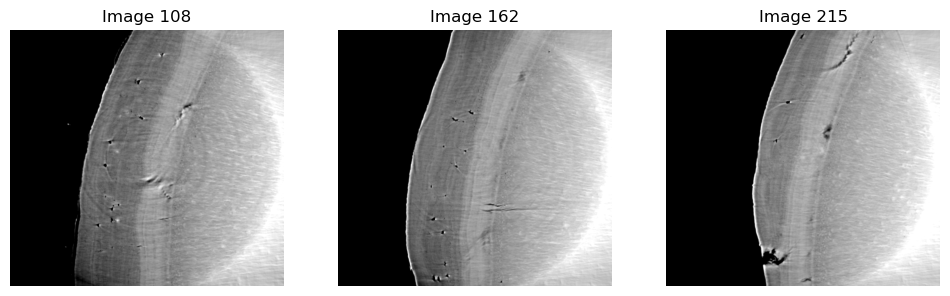

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, image, idx in zip(
    axes,
    [images[0], images[len(images) // 2], images[-1]],
    [indices[0], indices[len(indices) // 2], indices[-1]],
):
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Image {idx}")
    ax.set_axis_off()

In [2]:
"""
Crop them to remove much of the background and dentin

"""

'\nCrop them to remove much of the background and dentin\n\n'

In [3]:
"""
Normalise the stack of images to have a standard mean and standard deviation

"""

'\nNormalise the stack of images to have a standard mean and standard deviation\n\n'

In [4]:
"""
Find the 2d ridge orientation of one of these images

"""

'\nFind the 2d ridge orientation of one of these images\n\n'

In [5]:
"""
Find the 2d ridge frequency from one of these images

"""

'\nFind the 2d ridge frequency from one of these images\n\n'

In [ ]:
"""
Apply Gabor filters to this image in 2d

"""

In [6]:
"""
Find the 3d ridge orientation for the stack of images

"""

'\nFind the 3d ridge orientation for the stack of images\n\n'

In [7]:
"""
Find the 3d ridge frequency for the stack of images

"""

'\nFind the 3d ridge frequency for the stack of images\n\n'

In [ ]:
"""
Apply Gabor filters in 3d

"""